In [1]:
import numpy
import pandas

import matplotlib
from matplotlib import pyplot
%matplotlib inline

import scipy
from scipy import stats # TODO vedere perché non fa chiamare il modulo direttamente

import gmaps

<IPython.core.display.Javascript object>

## Creazione della mappa

invece che uno scatterplot con dei raggi, la libreria ci consente solo di fare una heatmap (eventualmente pesata)


In [2]:
roma = pandas.read_csv("../data/Roma_towers.csv")
coordinate = roma[['lat', 'lon']].values

In [3]:
heatmap = gmaps.heatmap(coordinate)
gmaps.display(heatmap)

# TODO scrivere che dietro queste due semplici linee ci sta un pomeriggio intero di smadonnamenti

In [4]:
colosseo = (41.890183, 12.492369)

In [5]:
import gmplot
from gmplot import GoogleMapPlotter

# gmap = gmplot.from_geocode("San Francisco")

mappa = gmplot.GoogleMapPlotter(41.890183, 12.492369, 12)

#gmap.plot(latitudes, longitudes, 'cornflowerblue', edge_width=10)
#gmap.plot((41.890183, 41.891183), (12.492369, 12.493369), 'cornflowerblue', edge_width=10)
#gmap.scatter(more_lats, more_lngs, '#3B0B39', size=40, marker=False)
#gmap.scatter(marker_lats, marker_lngs, 'k', marker=True)
#gmap.heatmap(heat_lats, heat_lngs)

#mappa.scatter((41.890183, 41.891183), (12.492369, 12.493369), color='#3B0B39', size=40, marker=False)

#mappa.scatter(roma.lat.values,
#              roma.lon.values,
#              color='#3333ff',
#              size=0,
#              marker=False)

mappa.heatmap(roma.lat.values,roma.lon.values)

mappa.draw("../html/heatmap.html")
#print a

### NOTE guardando la mappa

Sembrano esserci dei problemi con la posizione delle antenne: ci sono antenne sul tevere, su ponte Sisto, dentro il parchetto di Castel Sant'Angelo, in mezzo al pratone della Sapienza, in cima al dipartimento di Fisica...


Inoltre sembra esserci una strana clusterizzazione lungo le vie di traffico principali. Questo è ragionevole nell'ottica di garantire la copertura in una città con grossi flussi turistici come Roma, ma probabilmente non a tal punto da rendere plausibile la presenza di 7 antenne attorno a piazza Panteon. Ci sono anche coppie di antenne isolate che sembrano distare tra loro pochi metri. Probabilmente sono artefatti di ricostruzione.

Probabilmente l'algoitmo di ricostruzione di Mozilla ha diversi problemi. Se questa è la situazione delle antenne non oso pensare alla situazione dei router wifi.

Queste misure e queste ricostruzioni devono essere precise, perché è su queste che si poggerà il loro futuro servizio di geolocalizzazione.

Bisognerebbe farglielo presente (magari ci prendono a lavorare da loro :-) )



## Analisi del raggio di copertura delle antenne

dato che ci servirà fare un grafico con scale logaritmiche teniamo solo i dati con
> range =! 0

In [6]:

# condizioni di filtro
raggioMin = 1
# raggioMax = 1000
raggiPositivi = roma.range >= raggioMin
# raggiCorti = roma.range < raggioMax

# query con le condizioni
#romaFiltrato = roma[raggiPositivi & raggiCorti]
romaFiltrato = roma[raggiPositivi]
raggi = romaFiltrato.range

print max(raggi)


41832


In [7]:

# logaritmic (base 2) binning in log-log (base 10) plots of integer histograms

def logBinnedHist(histogramResults):
    """
    histogramResults = numpy.histogram(...)
        OR matplotlib.pyplot.hist(...)
    
    returns x, y
    to be used with matplotlib.pyplot.step(x, y, where='post')
    """
    
    # TODO così funziona solo con l'istogramma di pyplot;
    # quello di numpy restituisce solo la tupla (values, binEdges)
    values, binEdges, others = histogramResults
    
    # print binEdges
    
    # TODO
    # if 0 in binEdges:
    #     return "error: log2(0) = ?"
    
    # print len(values), len(binEdges)
    
    # print binEdges # TODO vedere quando non si parte da 1
    
    # int arrotonda all'intero inferiore
    linMin = min(binEdges)
    linMax = max(binEdges)
    
    # print linMin, linMax
    
    logStart = int(numpy.log2(linMin))
    logStop = int(numpy.log2(linMax))
    
    # print logStart, logStop
    
    nLogBins = logStop - logStart + 1
    
    # print nLogBins
    
    logBins = numpy.logspace(logStart, logStop, num=nLogBins, base=2, dtype=int)
    # print logBins
    
    # 1,2,4,8,16,32,64,128,256,512,1024
    
    ######################
    
    linStart = 2**logStop + 1
    linStop = linMax
    
    # print linStart, linStop
    
    nLinBins = linStop - linStart + 1
    
    # print nLinBins
    
    linBins = numpy.linspace(linStart, linStop, num=nLinBins, dtype=int)
    
    # print linBins
    
    ######################
    
    bins = numpy.append(logBins, linBins)
    
    # print bins
    
    # print len(bins)
    
    totalValues, binEdges, otherBinNumbers = scipy.stats.binned_statistic(raggi.values,
                                                                         raggi.values,
                                                                         statistic='count',
                                                                         bins=bins)
    
    # print totalValues
    # print len(totalValues)
    
    # uso le proprietà dei logaritmi in base 2:
    # 2^(n+1) - 2^n = 2^n
    correzioniDatiCanalizzatiLog = numpy.delete(logBins, -1)
    
    # print correzioniDatiCanalizzatiLog
    
    # print len(correzioniDatiCanalizzatiLog)
    
    correzioniDatiCanalizzatiLin = numpy.ones(nLinBins, dtype=int)
    
    # print correzioniDatiCanalizzatiLin
    
    # print len(correzioniDatiCanalizzatiLin)
    
    correzioniDatiCanalizzati = numpy.append(correzioniDatiCanalizzatiLog, correzioniDatiCanalizzatiLin)
    
    # print correzioniDatiCanalizzati
    
    # print len(correzioniDatiCanalizzati)
    
    
    
    
    x = numpy.concatenate(([0], bins))
    conteggi = totalValues/correzioniDatiCanalizzati
    
    # TODO caso speciale per il grafico di sotto
    # (per non fare vedere la parte oltre l'ultima potenza di 2)
    l = len(correzioniDatiCanalizzatiLin)
    conteggi[-l:] = numpy.zeros(l, dtype='int')
    
    y = numpy.concatenate(([0], conteggi, [0]))
    
    return x, y


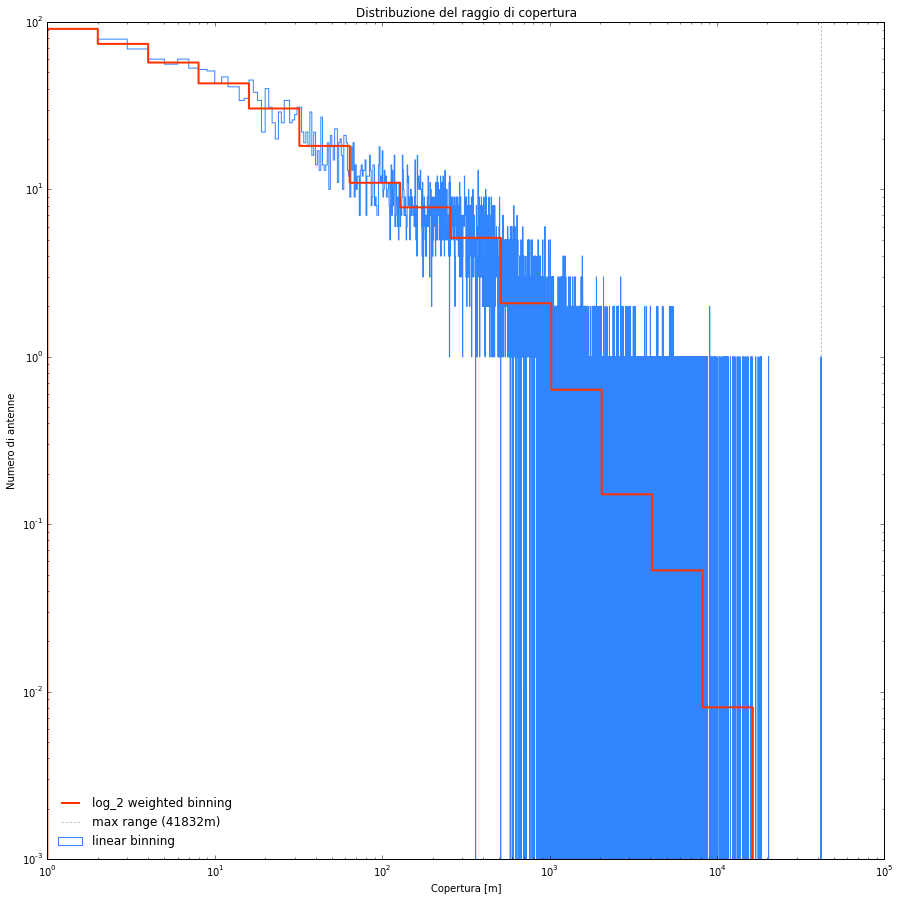

In [8]:

# creazione di un istogramma log-log per la distribuzione del raggio di copertura

# TODO provare a raggruppare le code
# esempio: con bins=100
# oppure con canalizzazione a logaritmo di 2, ma mediato
# in modo che venga equispaziato nel grafico logaritmico
# il programma vuole pesati i dati e non i canali
# si potrebbe implementare una mappa che pesa i dati
# secondo la funzione divisione intera per logaritmo di 2
# TODO mettere cerchietto che indica il range massimo oppure scritta in rosso "20341 m!"
# TODO spiegare perché ci sono così tanti conteggi a 1,2,4,... metri
# TODO ricavare il range dai dati grezzi, facendo un algoritmo di clustering
# sulle varie osservazioni delle antenne. machine learning?
# TODO scrivere funzione che fa grafici logaritmici con canali
# equispaziati nel plot logaritmico (canali pesati)

# impostazioni plot complessivo
# pyplot.figure(figsize=(20,8)) # dimensioni in pollici
pyplot.figure(figsize=(15,15))
matplotlib.pyplot.xlim(10**0,10**5)
matplotlib.pyplot.ylim(10**-3,10**2)
pyplot.title('Distribuzione del raggio di copertura')
pyplot.ylabel("Numero di antenne")
pyplot.xlabel("Copertura [m]")
# pyplot.gca().set_xscale("log")
# pyplot.gca().set_yscale("log")
pyplot.xscale("log")
pyplot.yscale("log")

# lin binning
distribuzioneRange = pyplot.hist(raggi.values,
                                bins=max(raggi)-min(raggi),
                                histtype='step',
                                color='#3385ff',
                                label='linear binning')

# log_2 binning
xLog2, yLog2 = logBinnedHist(distribuzioneRange)
matplotlib.pyplot.step(xLog2, yLog2, where='post', color='#ff3300', linewidth=2, label='log_2 weighted binning') #where = mid OR post
# matplotlib.pyplot.plot(xLog2, yLog2)

# linea verticale ad indicare il massimo grado
pyplot.axvline(x=max(raggi), color='#808080', linestyle='dotted', label='max range (41832m)')

# legenda e salvataggio
pyplot.legend(loc='lower left', frameon=False)
pyplot.savefig('../img/range/infinite_log_binning.svg', format='svg', dpi=600, transparent=True)



### Frequency-rank

In [9]:
# istogramma sugli interi
unique, counts = numpy.unique(raggi.values, return_counts=True)
# print numpy.asarray((unique, counts)).T
rank = numpy.arange(1,len(unique)+1)
frequency = numpy.array(sorted(counts, reverse=True))

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


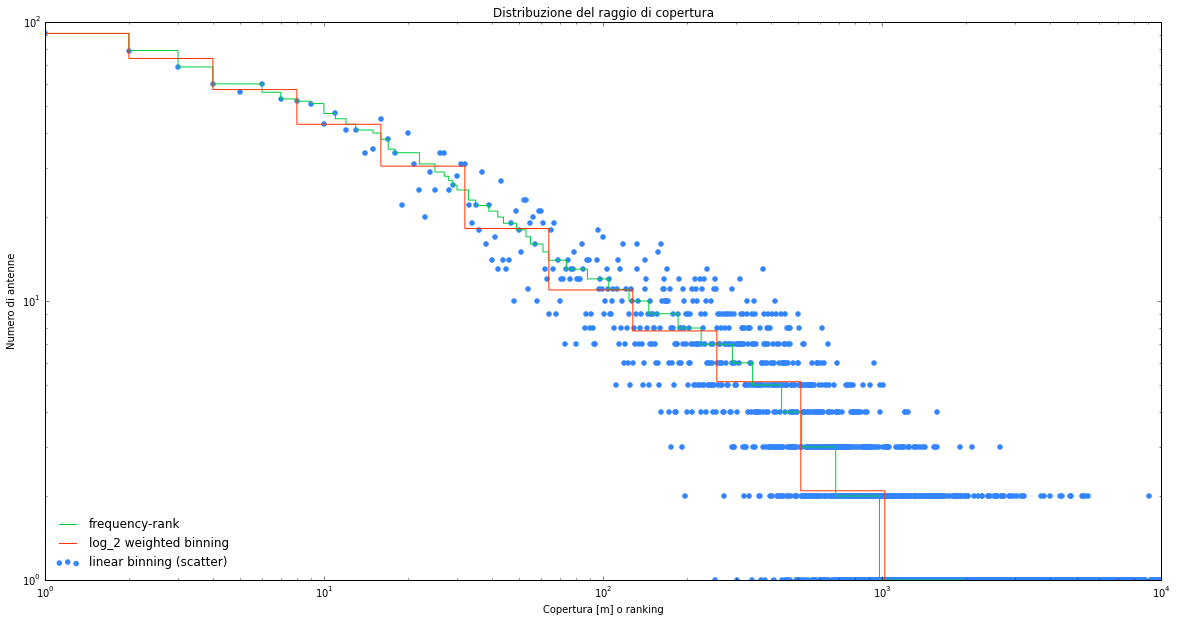

In [10]:
pyplot.figure(figsize=(20,10))
pyplot.title('Distribuzione del raggio di copertura')
pyplot.ylabel("Numero di antenne")
pyplot.xlabel("Copertura [m] o ranking")
pyplot.xscale("log")
pyplot.yscale("log")
matplotlib.pyplot.xlim(10**0,10**4)
matplotlib.pyplot.ylim(10**0,10**2)

matplotlib.pyplot.step(x=rank, y=frequency, where='post', label='frequency-rank', color='#00cc44')

matplotlib.pyplot.scatter(x=unique, y=counts, marker='o', color='#3385ff', label='linear binning (scatter)')
matplotlib.pyplot.step(xLog2, yLog2, where='post', color='#ff3300', label='log_2 weighted binning')

pyplot.legend(loc='lower left', frameon=False)
pyplot.savefig('../img/range/range_distribution.svg', format='svg', dpi=600, transparent=True)



### Cumulative histogram

the cumulative distribution function cdf(x) is the probability that a real-valued random variable X will take a value less than or equal to x

In [11]:
conteggi, binEdges = numpy.histogram(raggi.values,
                                bins=max(raggi)-min(raggi))
conteggiCumulativi = numpy.cumsum(conteggi)
valoriRaggi = numpy.delete(binEdges, -1)
N = len(raggi.values)

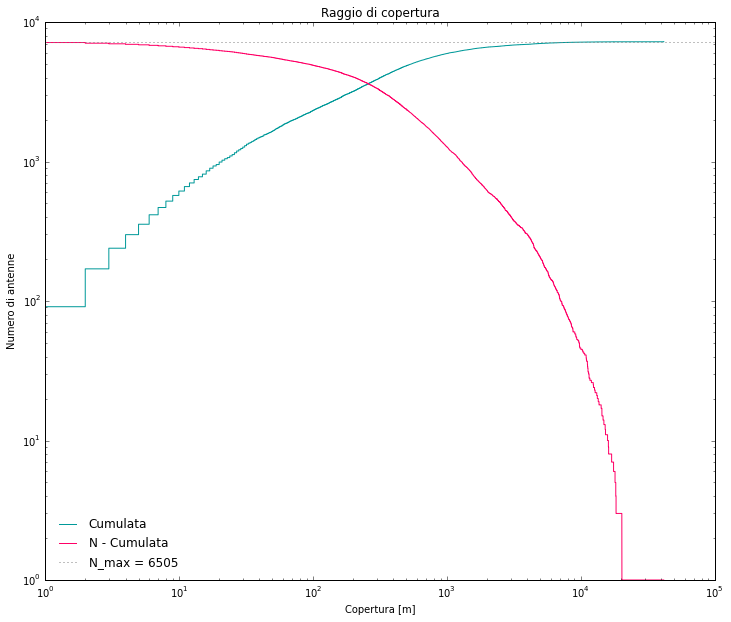

In [12]:

pyplot.figure(figsize=(12,10))
pyplot.title('Raggio di copertura')
pyplot.ylabel("Numero di antenne")
pyplot.xlabel("Copertura [m]")
pyplot.xscale("log")
pyplot.yscale("log")
matplotlib.pyplot.xlim(10**0,10**5)
matplotlib.pyplot.ylim(10**0,10**4)

matplotlib.pyplot.step(x=valoriRaggi, y=conteggiCumulativi, where='post', label='Cumulata', color='#009999')
matplotlib.pyplot.step(x=valoriRaggi, y=N-conteggiCumulativi, where='post', label='N - Cumulata', color='#ff0066')

pyplot.axhline(y=N, color='#808080', linestyle='dotted', label='N_max = 6505')

pyplot.legend(loc='lower left', frameon=False)
pyplot.savefig('../img/range/range_cumulated_distribution.svg', format='svg', dpi=600, transparent=True)


In [13]:
# TODO fare fit a mano e controllare le relazioni tra i vari esponenti